In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib notebook

In [2]:
import numpy as np
import scipy.optimize
import scipy.ndimage
import matplotlib.pyplot as plt
import matplotlib.colors
import astropy.units as u
import astropy.visualization
import h5py
import named_arrays as na
# import kgpy.labeled
# import kgpy.vectors
# import kgpy.matrix
import esis

In [3]:
wavelength_interferometer = 633 * u.nm
wavelength_instrument = 630 * u.AA

In [4]:
esis_optics = esis.flights.f1.optics.models.design_single(num_distribution=0)
obscuration = esis_optics.central_obscuration
primary = esis_optics.primary_mirror
field_stop = esis_optics.field_stop
grating = esis_optics.grating

## Load Primary Mirror WFE data

In [5]:
path_primary_sn001 = r"C:\Users\byrdie\Kankelborg-Group\KSO\kso\kso_iii\engineering\esis\optics\components\mirrors\primary\parabolic\figure_testing\4sight_data\flight_pmsn001\PM_001_Figure_Promoted.h5"

In [6]:
file_primary_sn001 = h5py.File(path_primary_sn001, "r")

In [7]:
file_primary_sn001["measurement0"].keys()

<KeysViewHDF5 ['analyzed', 'fiducials', 'genraw', 'maskshapes', 'padding_offsets', 'roi_rect']>

In [8]:
data_primary = file_primary_sn001["measurement0"]["genraw"]["data"][...]
mask_primary = data_primary < 100
data_primary[~mask_primary] = 0

<IPython.core.display.Javascript object>


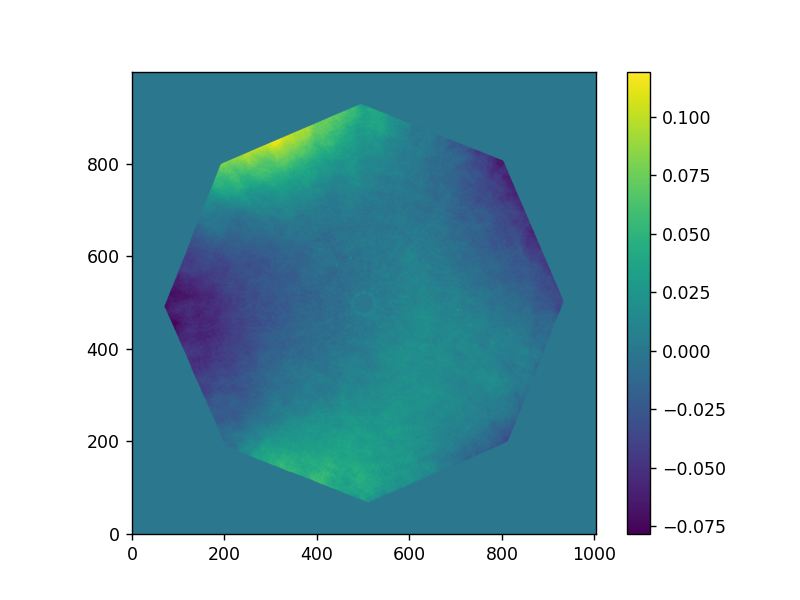

In [9]:
plt.figure()
plt.imshow((data_primary * mask_primary).T, origin="lower");
plt.colorbar();

In [10]:
vertices_pix_primary = np.array([
    [932.5, 502.5],
    [800.5, 807],
    [494, 930.5],
    [191, 800],
    [69.5, 491.5],
    [201.5, 188.5],
    [510.5, 67.5],
    [810.5, 199.5],
])
vertices_pix_primary = na.Cartesian2dVectorArray(
    x=na.ScalarArray(vertices_pix_primary[..., 0], axes=('vertex', )), 
    y=na.ScalarArray(vertices_pix_primary[..., 1], axes=('vertex', )),
)

## Remove tip, tilt, and defocus from Primary WFE

In [11]:
i_primary, j_primary = np.indices(data_primary.shape)
i_primary, j_primary = i_primary[mask_primary], j_primary[mask_primary]
i0_primary, j0_primary = i_primary.mean(), j_primary.mean()
# i_primary, j_primary = i_primary - i0_primary, j_primary - j0_primary
# coeff_primary, r, rank, s = np.linalg.lstsq(
#     a=np.array([i_primary*0+1, i_primary, j_primary, i_primary**2 + j_primary**2]).T, 
#     b=data_primary[mask_primary],
# )

# i_primary, j_primary = np.indices(data_primary.shape)
# i_primary, j_primary = i_primary - i0_primary, j_primary - j0_primary
# fit_primary = coeff_primary[0] + coeff_primary[1] * i_primary + coeff_primary[2] * j_primary + coeff_primary[3] * (i_primary**2 + j_primary**2)
# wfe_primary = data_primary - fit_primary
wfe_primary = data_primary

<IPython.core.display.Javascript object>


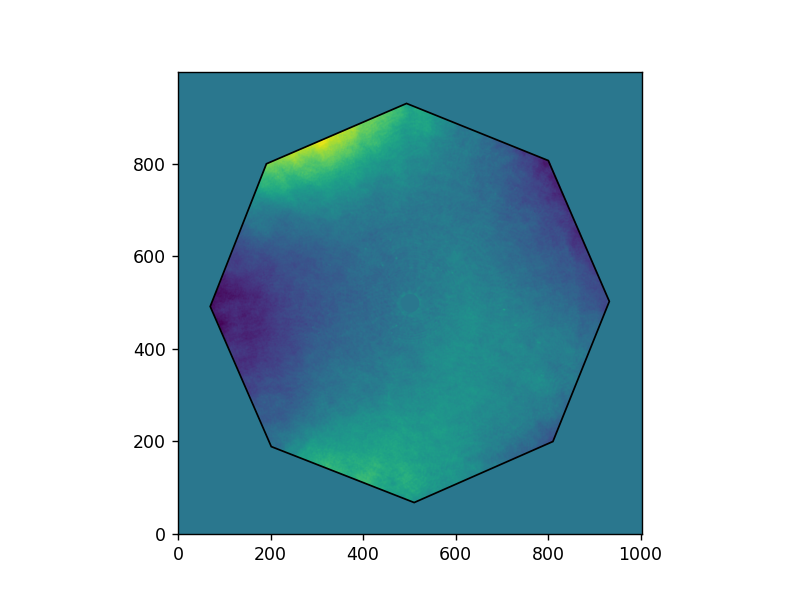

In [12]:
plt.figure()
plt.imshow(wfe_primary.T * mask_primary.T, origin="lower")
plt.fill(vertices_pix_primary.x.ndarray, vertices_pix_primary.y.ndarray, facecolor='none', edgecolor='black')

## Calculate the scale of the Primary WFE data

In [13]:
vertices_obscuration = obscuration.surface.aperture.vertices.xy
vertices_primary = primary.surface.aperture.vertices.xy

In [14]:
rotation_channel = na.Cartesian2dRotationMatrixArray(22.5 * u.deg)

In [15]:
def transform(
    x: np.ndarray,
    vertices_pix: na.Cartesian2dVectorArray,
    vertices: na.Cartesian2dVectorArray,
    unit_length: u.Unit, 
    unit_angle: u.Unit,
):
    offset_x, offset_y, scale, rotation = x
    
    offset = na.Cartesian2dVectorArray(offset_x, offset_y)
    scale = scale * unit_length
    rotation = na.Cartesian2dRotationMatrixArray(rotation * unit_angle)
    
    vertices_test = rotation @ (scale * (vertices_pix - offset))
    
    residual = (vertices_test - vertices).length.rms()
    
    return residual.ndarray.value

In [16]:
unit_length = u.mm
unit_angle = u.deg

In [17]:
guess_primary = np.array([
    i0_primary,
    j0_primary,
    (vertices_primary.x.ptp() / vertices_pix_primary.x.ptp()).ndarray.to(unit_length).value,
    0,
])
result = scipy.optimize.minimize(
    fun=transform, 
    x0=guess_primary, 
    args=(vertices_pix_primary, vertices_primary, unit_length, unit_angle),
    method="Nelder-Mead",
)
offset_x, offset_y, scale, rotation = result.x
offset = na.Cartesian2dVectorArray(offset_x, offset_y)
scale = scale * unit_length
rotation = rotation * unit_angle
rotation_matrix = na.Cartesian2dRotationMatrixArray(rotation)

offset_final = na.Cartesian2dVectorArray(*wfe_primary.shape) / 2

shift = offset_final - offset
wfe_primary = scipy.ndimage.shift(wfe_primary, shift=(shift.x, shift.y))
wfe_primary = scipy.ndimage.rotate(wfe_primary, rotation, reshape=False)
mask_primary = scipy.ndimage.shift(mask_primary.astype(float), shift=(shift.x, shift.y))
mask_primary = scipy.ndimage.rotate(mask_primary, rotation, reshape=False)
mask_primary = mask_primary > .5

wfe_primary = na.ScalarArray(wfe_primary, axes=("x", "y"))

rotation

<Quantity -0.90885188 deg>

In [18]:
coords_primary = na.Cartesian2dVectorArray(**na.indices(wfe_primary.shape))
coords_primary = scale * (coords_primary - offset_final)
coords_primary = rotation_channel @ coords_primary

In [19]:
vertices_obscuration_transformed = rotation_channel @ vertices_obscuration
vertices_primary_transformed = rotation_channel @ vertices_primary
vertices_pix_primary_transformed = rotation_channel @ rotation_matrix @ (scale * (vertices_pix_primary - offset))

<IPython.core.display.Javascript object>


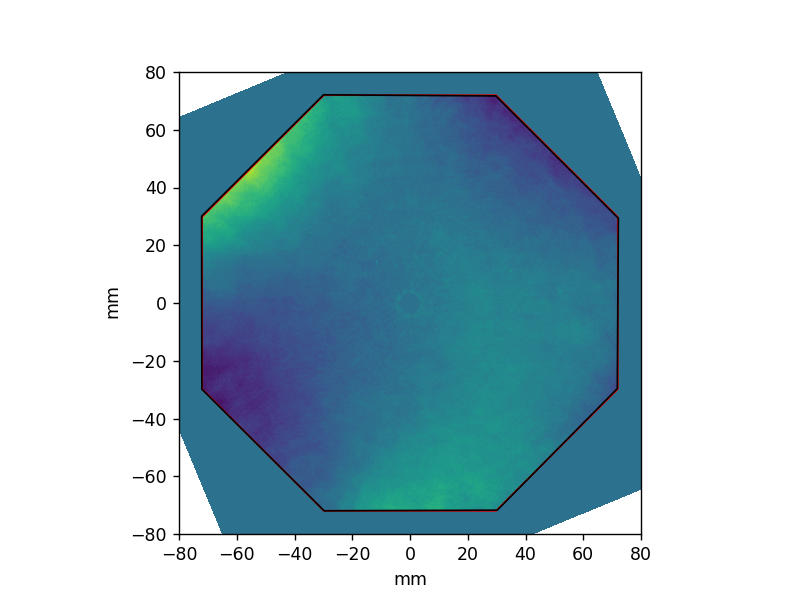

In [20]:
with astropy.visualization.quantity_support():
    plt.figure()
    plt.gca().set_aspect('equal')
    plt.pcolormesh(coords_primary.x.ndarray, coords_primary.y.ndarray, wfe_primary.ndarray)
    plt.fill(vertices_primary_transformed.x.ndarray, vertices_primary_transformed.y.ndarray, facecolor='none', edgecolor='red')
    plt.fill(vertices_pix_primary_transformed.x.ndarray, vertices_pix_primary_transformed.y.ndarray, facecolor='none', edgecolor='black')
    plt.gca().set_xlim(-80,80)
    plt.gca().set_ylim(-80, 80)

## Load the WFE data

In [21]:
path_grating_014 = r"C:\Users\byrdie\Kankelborg-Group\KSO\kso\kso_iii\engineering\esis\optics\components\mirrors\secondary\testing\radius_of_curvature\interferograms\euv_grating_014\EUV_014_Confocal_1.h5"

In [22]:
file_grating_014 = h5py.File(path_grating_014, "r")
file_grating_014.keys()

<KeysViewHDF5 ['4D', 'measurement0']>

In [23]:
file_grating_014["measurement0"].keys()

<KeysViewHDF5 ['Detectormask', 'analyzed', 'fiducials', 'genraw', 'maskshapes', 'padding_offsets', 'reserve_interferogram', 'roi_rect']>

In [24]:
file_grating_014["measurement0"]["genraw"]["data"]

<HDF5 dataset "data": shape (1004, 999), type "<f4">

In [25]:
mask = file_grating_014["measurement0"]["Detectormask"][...].astype(bool)

In [26]:
data_raw = file_grating_014["measurement0"]["genraw"]["data"][...]

<IPython.core.display.Javascript object>


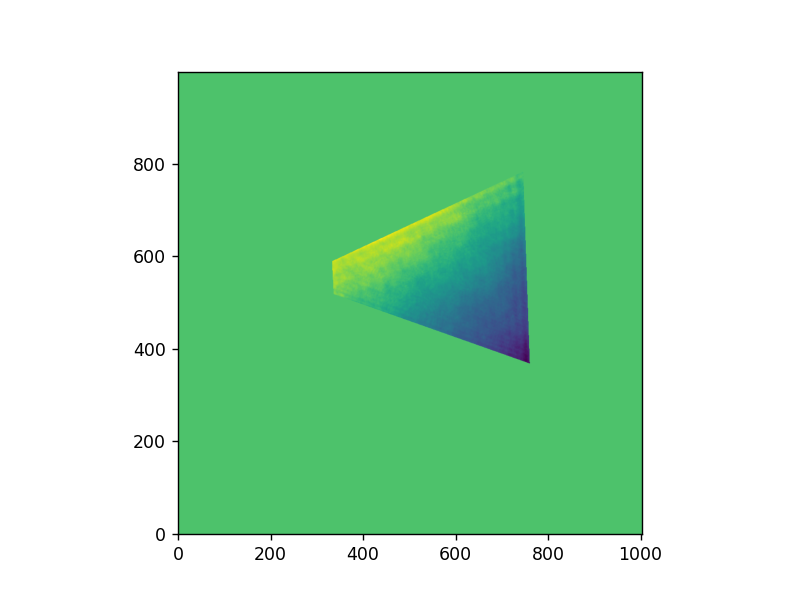

In [27]:
plt.figure()
plt.imshow((data_raw * mask).T, origin="lower");

In [28]:
vertices_pix = np.array([[335.5, 518.5], [759, 368], [745.5, 783.5], [332.5, 589.5], ])[::-1]
vertices_pix = na.Cartesian2dVectorArray(
    x=na.ScalarArray(vertices_pix[..., 0], axes=('vertex', )), 
    y=na.ScalarArray(vertices_pix[..., 1], axes=('vertex', )),
)
vertices_pix

Cartesian2dVectorArray(
    x=ScalarArray(
        ndarray=[332.5, 745.5, 759. , 335.5],
        axes=('vertex',),
    ),
    y=ScalarArray(
        ndarray=[589.5, 783.5, 368. , 518.5],
        axes=('vertex',),
    ),
)

## Remove tip, tilt, and defocus from the WFE

In [29]:
x, y = np.indices(data_raw.shape)

In [30]:
x.shape

(1004, 999)

In [31]:
x = x[mask]
y = y[mask]

In [32]:
x0 = x.mean()
y0 = y.mean()

In [33]:
x = x - x0
y = y - y0

In [34]:
a = np.array([x*0+1, x, y, x*x + y*y]).T
b = data_raw[mask]

In [35]:
coeff, r, rank, s = np.linalg.lstsq(a, b)

C:\Users\byrdie\AppData\Local\Temp\ipykernel_71696\4083987542.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coeff, r, rank, s = np.linalg.lstsq(a, b)


In [36]:
coeff

array([-4.87517021e-02, -4.26498130e-04,  5.31343816e-04, -6.60382219e-08])

In [37]:
x, y = np.indices(data_raw.shape)

In [38]:
fit = coeff[0] + coeff[1]*x + coeff[2]*y + coeff[3]*(x*x + y*y)

In [39]:
wfe = (data_raw - fit) * mask
wfe = (wfe * wavelength_interferometer / wavelength_instrument).to(u.dimensionless_unscaled)

<IPython.core.display.Javascript object>


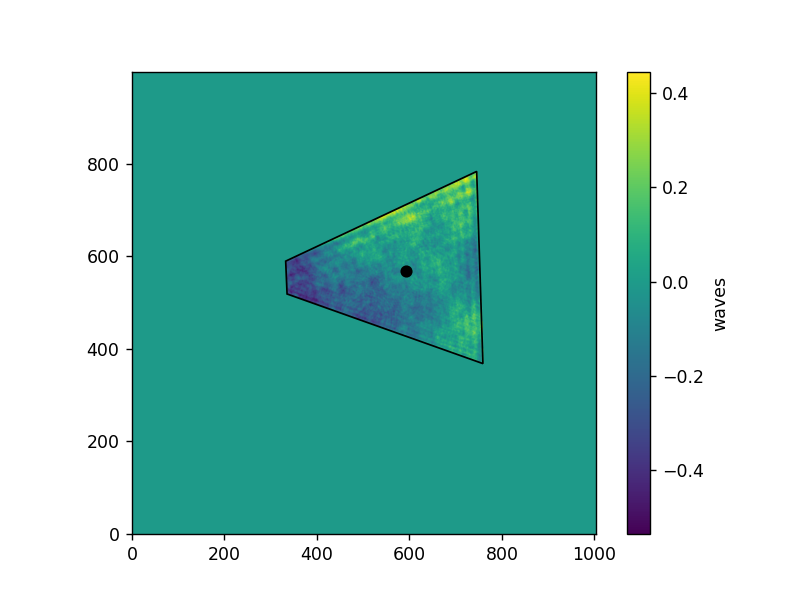

In [40]:
plt.figure()
plt.imshow(wfe.T, origin="lower")
plt.colorbar(label="waves")
plt.scatter(x0, y0, color='black')
plt.fill(vertices_pix.x.ndarray, vertices_pix.y.ndarray, facecolor='none', edgecolor='black')

## Calcuate the scale of the WFE data

In [41]:
grating.surface.aperture

IsoscelesTrapezoidalAperture(
    x_left=6.11374812 mm,
    x_right=22.76374812 mm,
    angle=45. deg,
    samples_wire=101,
    active=True,
    inverted=False,
    transformation=Cartesian3dTranslation(x=<Quantity -14.27374812 mm>, y=<Quantity 0. mm>, z=<Quantity 0. mm>),
    kwargs_plot=None,
)

In [42]:
vertices = grating.surface.aperture.transformation(grating.surface.aperture.vertices).xy
# vertices = esis_optics.transformation(grating.transformation(vertices)).xy
# vertices = na.Cartesian2dVectorArray(
#     x=vertices.x,
#     y=vertices.y.nominal
# )
vertices

Cartesian2dVectorArray(
    x=ScalarArray(
        ndarray=[-8.16,  8.49,  8.49, -8.16] mm,
        axes=('vertex',),
    ),
    y=ScalarArray(
        ndarray=[ 2.53239739,  9.4290532 , -9.4290532 , -2.53239739] mm,
        axes=('vertex',),
    ),
)

In [43]:
distance_radial = grating.distance_radial
distance_radial

<Quantity 20.74999998 mm>

In [44]:
scale_guess = (vertices.x.ptp() / vertices_pix.x.ptp()).ndarray
scale_guess

<Quantity 0.03903869 mm>

In [45]:
guess = np.array([
    x0, 
    y0,
    scale_guess.to(unit_length).value,
    0,
])

In [46]:
result = scipy.optimize.minimize(
    fun=transform, 
    x0=guess, 
    args=(vertices_pix, vertices, unit_length, unit_angle),
    method="Nelder-Mead",
    bounds=[
        (None, None),
        (None, None),
        (0, None),
        (None, None),
    ],
)
offset_x, offset_y, scale, rotation = result.x
offset = na.Cartesian2dVectorArray(offset_x, offset_y)
scale = scale * unit_length
rotation_matrix = na.Cartesian2dRotationMatrixArray(rotation * unit_angle)

In [47]:
offset

Cartesian2dVectorArray(x=539.1897745011963, y=564.6981808586426)

In [48]:
scale

<Quantity 0.04188733 mm>

In [49]:
scale_grating = field_stop.translation.z / (grating.translation.z - field_stop.translation.z)
scale_grating = scale_grating.nominal
scale_grating

<Quantity 2.66880171>

In [50]:
1000 / 374.7

2.6688017080330932

In [51]:
scale = scale * scale_grating

In [52]:
rotation * unit_angle

<Quantity -2.57275204 deg>

In [53]:
offset_final = na.Cartesian2dVectorArray(*wfe.shape) / 2

In [54]:
shift = offset_final - offset
wfe_shifted = scipy.ndimage.shift(wfe, shift=(shift.x, shift.y))
wfe_final = scipy.ndimage.rotate(wfe_shifted, rotation, reshape=False)
mask_shifted = scipy.ndimage.shift(mask.astype(float), shift=(shift.x, shift.y))
mask_final = scipy.ndimage.rotate(mask_shifted, rotation, reshape=False)
mask_final = mask_final > .5

In [55]:
shift

Cartesian2dVectorArray(x=-37.189774501196325, y=-65.19818085864256)

In [56]:
coords = na.Cartesian2dVectorArray(*np.indices(wfe.shape))
coords = scale * (coords - offset_final)
coords.x = coords.x + distance_radial * scale_grating

In [57]:
mask_final = mask_final & (coords.x >= obscuration.halfwidth)
mask_final = mask_final & (coords.x <= primary.width_clear / 2)

In [58]:
vertices_transformed = rotation_matrix @ (scale * (vertices_pix - offset))
vertices_transformed.x = vertices_transformed.x + distance_radial * scale_grating

<IPython.core.display.Javascript object>


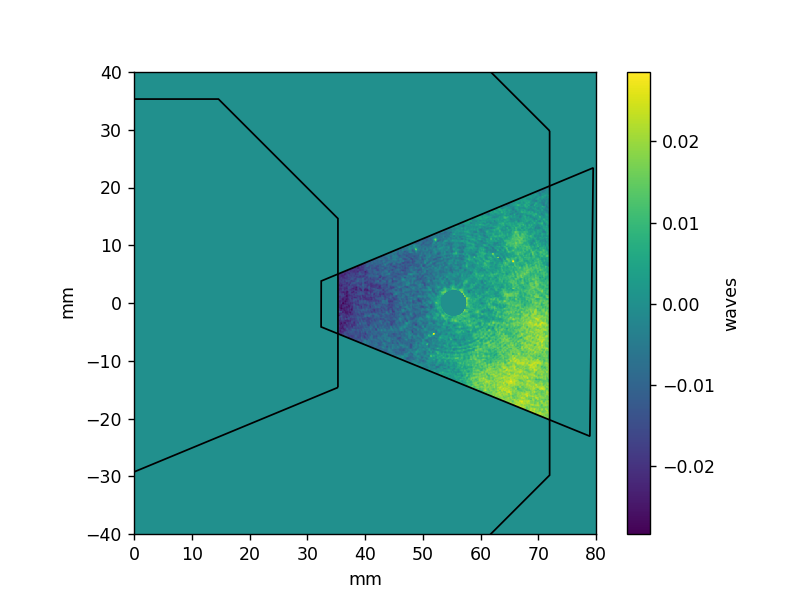

In [59]:
with astropy.visualization.quantity_support():
    plt.figure()
    plt.gca().set_aspect('equal')
    plt.gca().set_xlim(0, 80)
    plt.gca().set_ylim(-40, 40)
    plt.pcolormesh(coords.x, coords.y, wfe_primary.ndarray * mask_final)
#     plt.fill(vertices.x.array, vertices.y.array, facecolor='none', edgecolor='red')
    plt.fill(vertices_transformed.x.ndarray, vertices_transformed.y.ndarray, facecolor='none', edgecolor='black')
    plt.fill(vertices_primary_transformed.x.ndarray, vertices_primary_transformed.y.ndarray, facecolor='none', edgecolor='black')
    plt.fill(vertices_obscuration_transformed.x.ndarray, vertices_obscuration_transformed.y.ndarray, facecolor='none', edgecolor='black')
    plt.colorbar(label="waves")
    plt.savefig("grating_wfe.png")

## Calculate bounding rectangle

In [60]:
mask_rectangle = (coords.x[mask_final].min() <= coords.x) & (coords.x <= coords.x[mask_final].max())
mask_rectangle &= (coords.y[mask_final].min() <= coords.y) & (coords.y <= coords.y[mask_final].max())

<IPython.core.display.Javascript object>


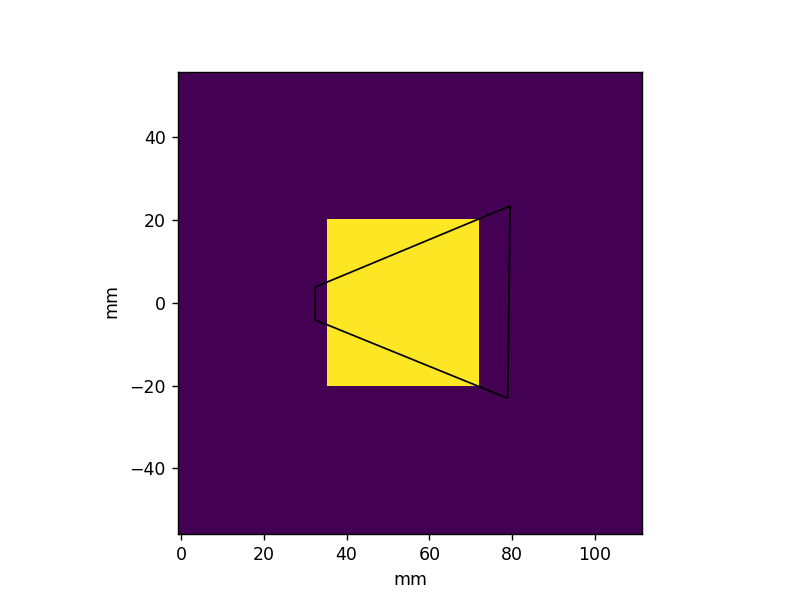

In [61]:
with astropy.visualization.quantity_support():
    plt.figure()
    plt.gca().set_aspect('equal')
    plt.pcolormesh(coords.x, coords.y, mask_rectangle)
    plt.fill(vertices_transformed.x.ndarray, vertices_transformed.y.ndarray, facecolor='none', edgecolor='black')

## Calculate the PSF

In [62]:
aperture = np.exp(-2j * np.pi * wfe_primary.ndarray * 0)
aperture[~mask_final] = 0
# aperture = mask_rectangle.astype(float)
aperture = np.pad(aperture, 1000)

In [63]:
psf = np.square(np.abs(np.fft.fftshift(np.fft.fft2(aperture))))

In [64]:
fx = np.fft.fftshift(np.fft.fftfreq(aperture.shape[0], d=scale))
fy = np.fft.fftshift(np.fft.fftfreq(aperture.shape[1], d=scale))

In [65]:
x_psf = np.arcsin(fx * wavelength_instrument).to(u.arcsec)
y_psf = np.arcsin(fy * wavelength_instrument).to(u.arcsec)
x_psf

<Quantity [-58.12148401, -58.08278795, -58.04409189, ...,  58.00539583,
            58.04409189,  58.08278795] arcsec>

<IPython.core.display.Javascript object>


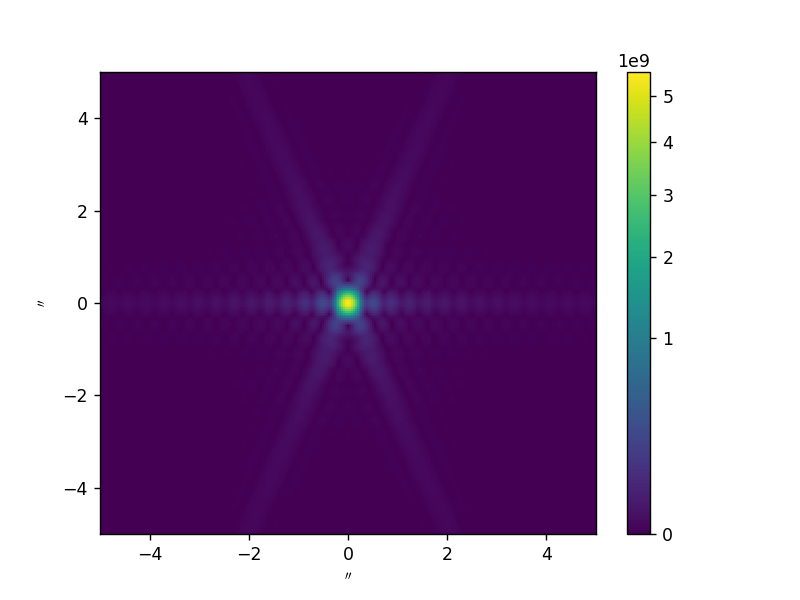

In [66]:
with astropy.visualization.quantity_support():
    plt.figure()
    plt.pcolormesh(
        *np.broadcast_arrays(x_psf[:, np.newaxis], y_psf[np.newaxis, :], subok=True), 
        psf,
        norm=matplotlib.colors.PowerNorm(0.5),
    )
    plt.colorbar()
    plt.gca().set_xlim(-5, 5)
    plt.gca().set_ylim(-5, 5)
    plt.savefig("grating_psf.png")

## Calculate the MTF

In [67]:
mtf = np.abs(np.fft.fft2(psf))
mtf = mtf / mtf[0]

In [68]:
x_mtf = np.fft.fftfreq(mtf.shape[0], d=np.diff(x_psf).mean())
y_mtf = np.fft.fftfreq(mtf.shape[1], d=np.diff(y_psf).mean())

<IPython.core.display.Javascript object>


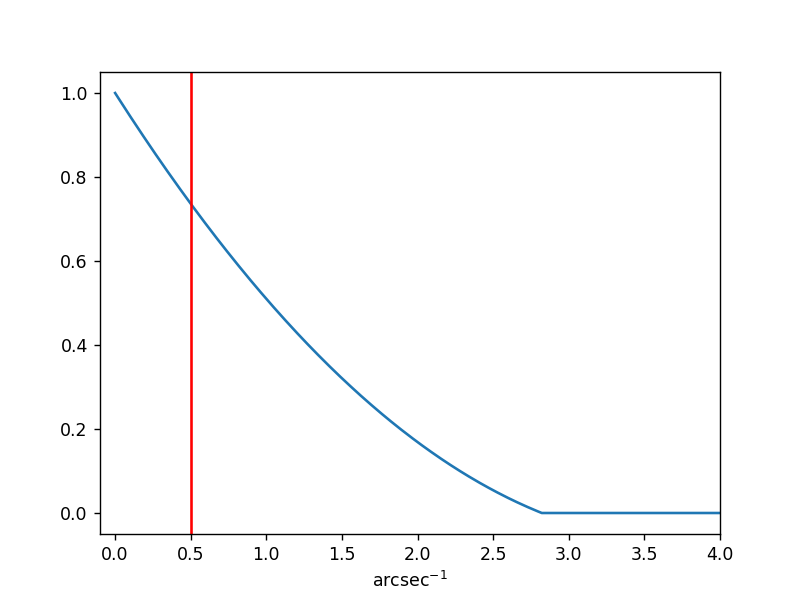

In [69]:
cutoff = mtf.shape[0] // 2
with astropy.visualization.quantity_support():
    plt.figure()
    plt.plot(x_mtf[:cutoff], mtf[:cutoff, 0])
    plt.axvline(0.5 / u.arcsec, color="red")
    plt.gca().set_xlim(-.1,4)
    plt.savefig("grating_mtf.png")

## Check against Rayleigh Criterion

In [70]:
diameter_aperture = coords.x[mask_final].max() - coords.x[mask_final].min()
diameter_aperture

<Quantity 36.55499685 mm>

In [71]:
criterion = ((wavelength_instrument / diameter_aperture).to(u.dimensionless_unscaled) * u.rad).to(u.arcsec)
criterion

<Quantity 0.35548308 arcsec>

<IPython.core.display.Javascript object>


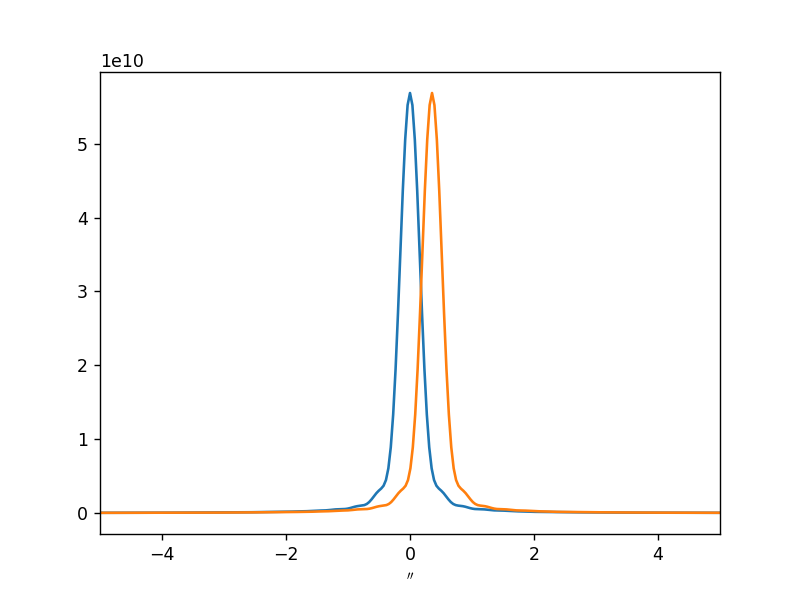

In [72]:
psf_x = np.sum(psf, axis=~0)

with astropy.visualization.quantity_support():
    plt.figure()
    plt.plot(y_psf, psf.sum(0))
    plt.plot(y_psf + criterion, psf.sum(0))
    plt.xlim(-5, 5)

In [73]:
coords.y.mean(0)

<Quantity [-55.8385961 , -55.72680712, -55.61501814, -55.50322916,
           -55.39144018, -55.2796512 , -55.16786221, -55.05607323,
           -54.94428425, -54.83249527, -54.72070629, -54.60891731,
           -54.49712833, -54.38533935, -54.27355036, -54.16176138,
           -54.0499724 , -53.93818342, -53.82639444, -53.71460546,
           -53.60281648, -53.4910275 , -53.37923852, -53.26744953,
           -53.15566055, -53.04387157, -52.93208259, -52.82029361,
           -52.70850463, -52.59671565, -52.48492667, -52.37313768,
           -52.2613487 , -52.14955972, -52.03777074, -51.92598176,
           -51.81419278, -51.7024038 , -51.59061482, -51.47882583,
           -51.36703685, -51.25524787, -51.14345889, -51.03166991,
           -50.91988093, -50.80809195, -50.69630297, -50.58451399,
           -50.472725  , -50.36093602, -50.24914704, -50.13735806,
           -50.02556908, -49.9137801 , -49.80199112, -49.69020214,
           -49.57841315, -49.46662417, -49.35483519, -49.24304

In [74]:
criterion / np.diff(y_psf).mean()

<Quantity 9.1712537>

In [75]:
psf_shifted = scipy.ndimage.shift(psf.sum(0), float(criterion / np.diff(x_psf).mean()))

<IPython.core.display.Javascript object>


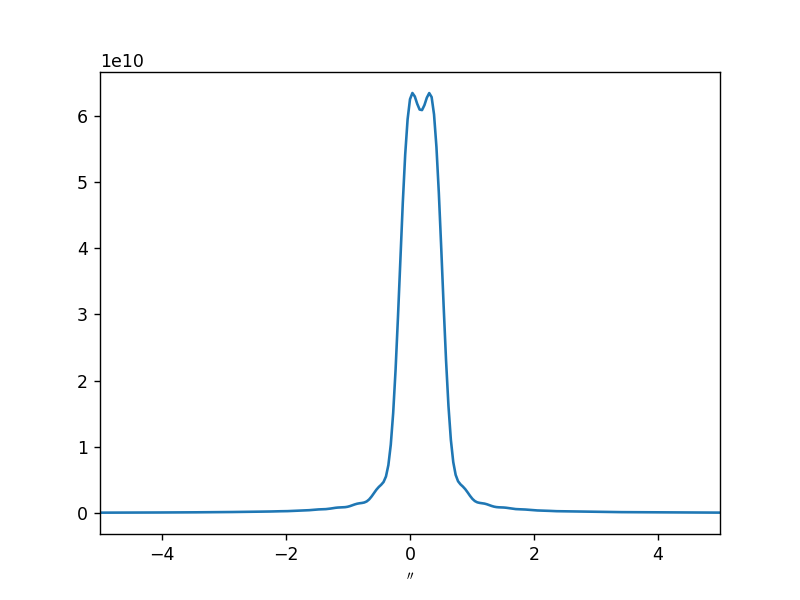

In [76]:
with astropy.visualization.quantity_support():
    plt.figure()
    plt.plot(y_psf, psf.sum(0) + psf_shifted)
#     plt.plot(psf.sum(~0) + np.roll(psf.sum(~0), 8))
#     plt.plot(np.roll(psf.sum(~0), 7)
    plt.xlim(-5, 5)

In [77]:
.4/2.2

0.18181818181818182

In [78]:
y_psf.shape

(2999,)

In [79]:
psf.shape

(3004, 2999)

In [80]:
grating.surface.aperture

IsoscelesTrapezoidalAperture(
    x_left=6.11374812 mm,
    x_right=22.76374812 mm,
    angle=45. deg,
    samples_wire=101,
    active=True,
    inverted=False,
    transformation=Cartesian3dTranslation(x=<Quantity -14.27374812 mm>, y=<Quantity 0. mm>, z=<Quantity 0. mm>),
    kwargs_plot=None,
)

In [81]:
(80 * u.urad).to(u.arcsec)

<Quantity 16.5011845 arcsec>

In [82]:
primary.clear_half_width

AttributeError: 'PrimaryMirror' object has no attribute 'clear_half_width'